# Previsão de Topos e Fundos no Bitcoin
Este notebook apresenta o fluxo completo do projeto ajustado para execução passo a passo com visualização integrada.

## Objetivo
Identificar pontos de reversão (Topos e Fundos) no preço do Bitcoin utilizando indicadores técnicos e modelos de Machine Learning (Regressão Logística, Random Forest e LSTM).

In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from data_handler import get_historical_data
from feature_engineering import apply_feature_engineering_mtf, label_zigzag
from model_trainer import train_eval_models, plot_confusion_matrix, plot_predictions_on_price

# Configurações visuais
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Coleta de Dados Multitemporais
Para uma análise robusta, coletamos dados de 1h, 4h (base para o modelo) e 1d.

In [2]:
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

intervals = ['1h', '4h', '1d']
dfs = {}

for interval in intervals:
    file_path = f'data/btc_historical_{interval}.parquet'
    if not os.path.exists(file_path):
        print(f"Baixando dados {interval}...")
        df_tmp = get_historical_data(symbol='BTCUSDT', interval=interval, days=365)
        df_tmp.to_parquet(file_path, index=False)
        dfs[interval] = df_tmp
    else:
        print(f"Carregando {interval} do arquivo.")
        dfs[interval] = pd.read_parquet(file_path)

print("\nDados carregados com sucesso.")

Carregando 1h do arquivo.
Carregando 4h do arquivo.
Carregando 1d do arquivo.

Dados carregados com sucesso.


## 2. Engenharia de Atributos e Rotulagem (ZigZag)
Nesta etapa, calculamos indicadores técnicos em múltiplos tempos gráficos e definimos os Topos e Fundos usando o algoritmo ZigZag (3% de variação).

In [3]:
print("Processando Features e Rótulos...")
df_processed = apply_feature_engineering_mtf(dfs['1h'], dfs['4h'], dfs['1d'])
df_processed = label_zigzag(df_processed, threshold=0.03)
df_processed = df_processed.dropna().reset_index(drop=True)

print(f"\nTotal de registros: {len(df_processed)}")
print("Distribuição de Rótulos:")
print(df_processed['label'].value_counts().rename({0: 'Nada', 1: 'Topo', 2: 'Fundo'}))

# Salvando o processado para uso
df_processed.to_parquet('data/btc_processed_4h.parquet', index=False)

Processando Features e Rótulos...
Calculando features de 4h (Base)...
Calculando features de referência de 1h e 1d...
Mesclando tempos gráficos na base de 4h...

Total de registros: 1981
Distribuição de Rótulos:
Nada     1778
Topo      104
Fundo      99
Name: label, dtype: int64


In [4]:
df_processed.head()

,timestamp,open,high,low,close,volume,sma_20,rsi,macd_diff,close_vs_sma20,...,macd_diff_lag2,close_vs_sma20_lag1,close_vs_sma20_lag2,rsi_1h,macd_diff_1h,close_vs_sma20_1h,rsi_1d,macd_diff_1d,close_vs_sma20_1d,label
0,2025-02-09 00:00:00,96444.75,97300.00,96360.14,97300.00,2064.37300,96987.5095,49.526451,95.717864,0.003222,...,0.472922,-0.005632,-0.005095,49.467596,82.607349,0.002186,40.068528,-777.895154,-0.04798,0
1,2025-02-09 04:00:00,97299.99,97323.09,96777.77,97057.83,1130.18566,97009.7795,48.198657,127.132612,0.000495,...,22.407651,0.003222,-0.005632,61.495633,128.440885,0.009567,40.068528,-777.895154,-0.04798,0
2,2025-02-09 08:00:00,97057.83,97294.46,96509.96,96554.01,1810.78846,96969.6965,45.467575,113.653630,-0.004287,...,95.717864,0.000495,0.003222,56.695707,89.247143,0.004924,40.068528,-777.895154,-0.04798,0
3,2025-02-09 12:00:00,96554.01,96703.99,95700.00,96488.15,3215.85687,96884.3235,45.107757,100.433262,-0.004089,...,127.132612,-0.004287,0.000495,46.187276,-5.925255,-0.001887,40.068528,-777.895154,-0.04798,0
4,2025-02-09 16:00:00,96488.14,96567.80,95888.88,96064.74,1504.31820,96743.6610,42.764665,65.021109,-0.007018,...,113.653630,-0.004089,-0.004287,47.800492,-80.274077,-0.002273,40.068528,-777.895154,-0.04798,0


### 2.1 Visualizando os Rótulos no Preço
Vamos ver como o algoritmo ZigZag identificou os pontos de reversão que serviram de alvo para o modelo.

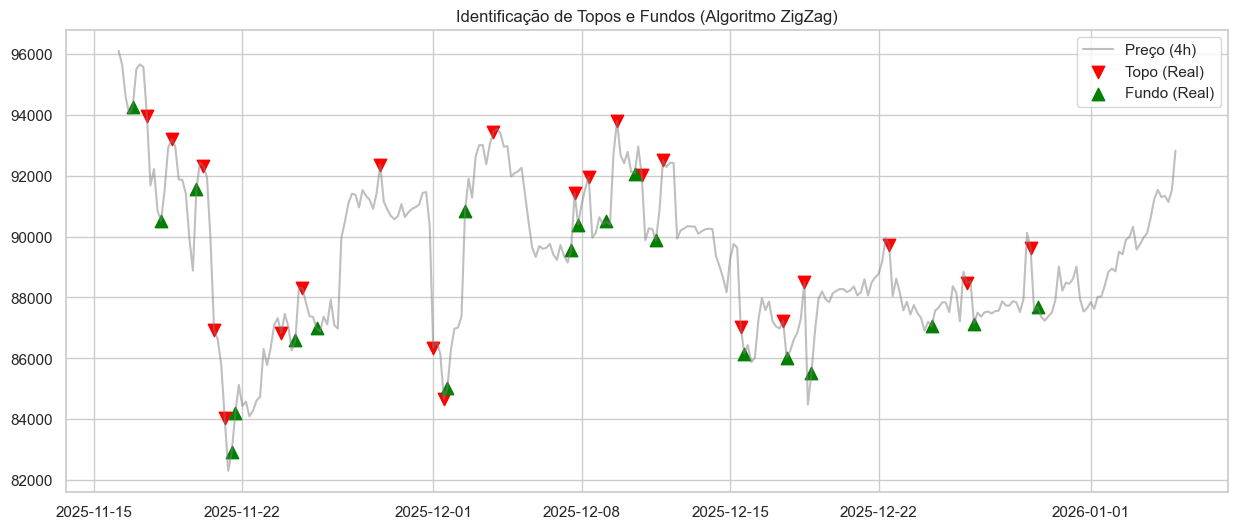

In [5]:
sample = df_processed.tail(300) # Mostrar os últimos 300 períodos de 4h
plt.figure(figsize=(15, 6))
plt.plot(sample['timestamp'], sample['close'], label='Preço (4h)', color='gray', alpha=0.5)

tops = sample[sample['label'] == 1]
bottoms = sample[sample['label'] == 2]

plt.scatter(tops['timestamp'], tops['close'], color='red', label='Topo (Real)', marker='v', s=80)
plt.scatter(bottoms['timestamp'], bottoms['close'], color='green', label='Fundo (Real)', marker='^', s=80)

plt.title("Identificação de Topos e Fundos (Algoritmo ZigZag)")
plt.legend()
plt.show()

## 2.2 Validação Estatística das Labels
Para garantir que o modelo não está tentando aprender padrões aleatórios, realizamos um teste de hipótese (**Teste t de Student**) nas variáveis de **RSI** (Momentum) e **BB_WIDTH** (Volatilidade). 

**Objetivo:** Confirmar se o "p-valor" é menor que 0.05. Se for, podemos afirmar com 95% de confiança que os alvos (Topos e Fundos) são estados estatisticamente diferentes do ruído do mercado.

=== RELATÓRIO DE SIGNIFICÂNCIA ESTATÍSTICA ===

--- Variável: RSI ---
Média Mercado (Nada): 51.0056
Média em Topos: 49.5177 | p-valor vs Nada: 0.35350181 (Não Significativo)
Média em Fundos: 43.5316 | p-valor vs Nada: 0.00000012 (✓ Significativo)
--------------------------------------------------
--- Variável: BB_WIDTH ---
Média Mercado (Nada): 5.1764
Média em Topos: 7.0703 | p-valor vs Nada: 0.00000304 (✓ Significativo)
Média em Fundos: 7.6247 | p-valor vs Nada: 0.00000007 (✓ Significativo)
--------------------------------------------------


C:\Users\dougl\AppData\Local\Temp\ipykernel_28248\2117980348.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=var, data=df_processed, ax=axes[i], palette='viridis')
C:\Users\dougl\AppData\Local\Temp\ipykernel_28248\2117980348.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['Nada', 'Topo', 'Fundo'])
C:\Users\dougl\AppData\Local\Temp\ipykernel_28248\2117980348.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=var, data=df_processed, ax=axes[i], palette='viridis')
C:\Users\dougl\AppData\Local\Temp\ipykernel_28248\2117980348.py:27: UserWarning: FixedFormatter should only be used together with FixedLoc

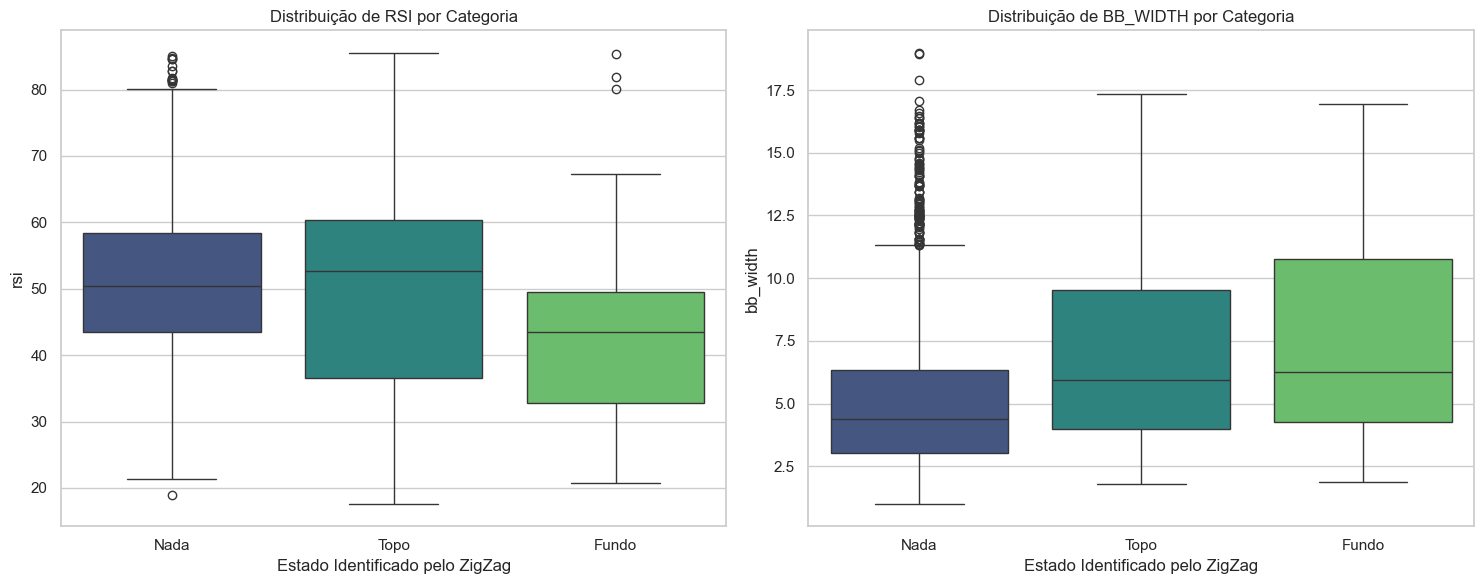

In [6]:
from scipy import stats

# Selecionamos as variáveis que melhor representam o estado do mercado
vars_to_test = ['rsi', 'bb_width']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

print("=== RELATÓRIO DE SIGNIFICÂNCIA ESTATÍSTICA ===\n")

for i, var in enumerate(vars_to_test):
    # Separação dos grupos baseada nas labels do ZigZag (0=Nada, 1=Topo, 2=Fundo)
    group0 = df_processed[df_processed['label'] == 0][var]
    group1 = df_processed[df_processed['label'] == 1][var]
    group2 = df_processed[df_processed['label'] == 2][var]
    
    # Teste t de Student (Welch's t-test para variâncias desiguais)
    t_top, p_top = stats.ttest_ind(group1, group0, equal_var=False)
    t_bot, p_bot = stats.ttest_ind(group2, group0, equal_var=False)
    
    print(f"--- Variável: {var.upper()} ---")
    print(f"Média Mercado (Nada): {group0.mean():.4f}")
    print(f"Média em Topos: {group1.mean():.4f} | p-valor vs Nada: {p_top:.8f} ({'✓ Significativo' if p_top < 0.05 else 'Não Significativo'})")
    print(f"Média em Fundos: {group2.mean():.4f} | p-valor vs Nada: {p_bot:.8f} ({'✓ Significativo' if p_bot < 0.05 else 'Não Significativo'})")
    print("-" * 50)
    
    # Visualização via Boxplot para o TCC
    sns.boxplot(x='label', y=var, data=df_processed, ax=axes[i], palette='viridis')
    axes[i].set_xticklabels(['Nada', 'Topo', 'Fundo'])
    axes[i].set_title(f'Distribuição de {var.upper()} por Categoria')
    axes[i].set_xlabel('Estado Identificado pelo ZigZag')

plt.tight_layout()
plt.show()

## 3. Treinamento dos Modelos
Agora aplicamos o treinamento e avaliação. A função `train_eval_models` realiza split temporal, escalonamento e busca de hiperparâmetros.

In [7]:
# Executa o treinamento completo
results, y_test, test_dates, test_close = train_eval_models(df_processed)

Tamanho do treino: 1584, Sequências LSTM: (1574, 10, 18)
Tamanho do teste: 397, Sequências LSTM: (387, 10, 18)

Treinando Regressão Logística (Otimizando com Random Search)...
Melhores parâmetros RL: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.0013894954943731374}
Treinando Random Forest (Otimizando com Random Search)...
Melhores parâmetros RF: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}


Epoch 1/100


40/40 [==============================] - 4s 24ms/step - loss: 1.1427 - accuracy: 0.3177 - val_loss: 1.2045 - val_accuracy: 0.3524
Epoch 2/100
40/40 [==============================] - 0s 7ms/step - loss: 1.0954 - accuracy: 0.3852 - val_loss: 1.1574 - val_accuracy: 0.4254
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 1.0936 - accuracy: 0.4424 - val_loss: 1.2204 - val_accuracy: 0.3397
Epoch 4/100
40/40 [==============================] - 0s 7ms/step - loss: 1.0791 - accuracy: 0.4829 - val_loss: 1.1969 - val_accuracy: 0.

## 4. Avaliação de Resultados
Abaixo analisamos a performance de cada modelo de forma individual.

### 4.1 Logistic Regression (Baseline Otimizado)

Acurácia: 0.6770
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       331
           1       0.27      0.26      0.26        31
           2       0.16      0.60      0.25        25

    accuracy                           0.68       387
   macro avg       0.44      0.53      0.44       387
weighted avg       0.81      0.68      0.72       387



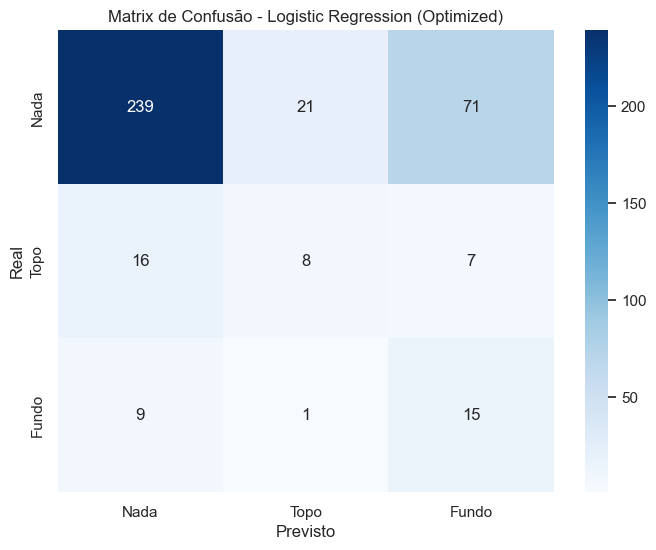

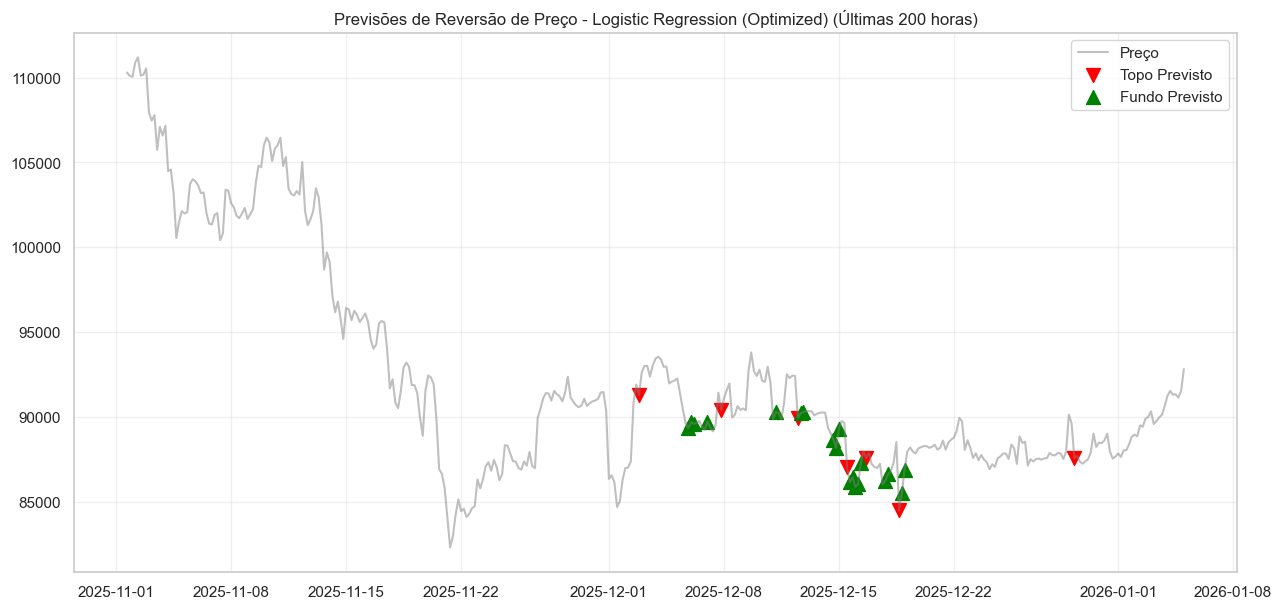

In [8]:
model_name = 'Logistic Regression (Optimized)'
metrics = results[model_name]

print(f"Acurácia: {metrics['accuracy']:.4f}")
print("Relatório de Classificação:")
print(metrics['report'])

plot_confusion_matrix(y_test, metrics['y_pred'], model_name, show=True)
plot_predictions_on_price(test_dates, test_close, y_test, metrics['y_pred'], model_name, show=True)

### 4.2 Random Forest (Ensemble Otimizado)

Acurácia: 0.8295
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       331
           1       0.39      0.23      0.29        31
           2       0.35      0.36      0.35        25

    accuracy                           0.83       387
   macro avg       0.54      0.50      0.51       387
weighted avg       0.81      0.83      0.82       387



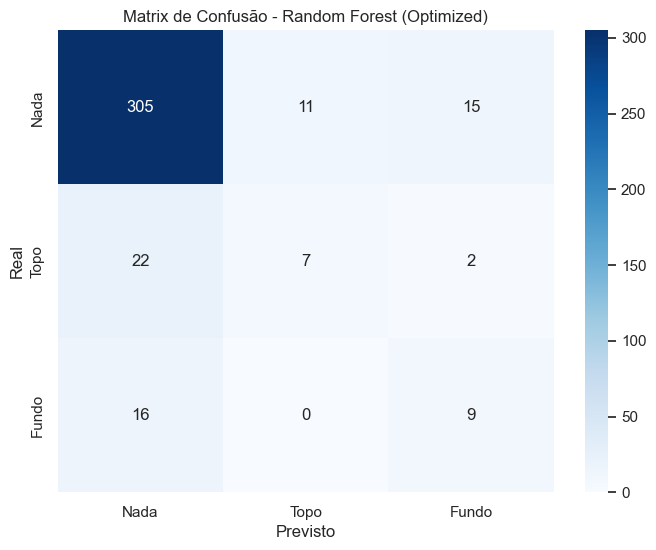

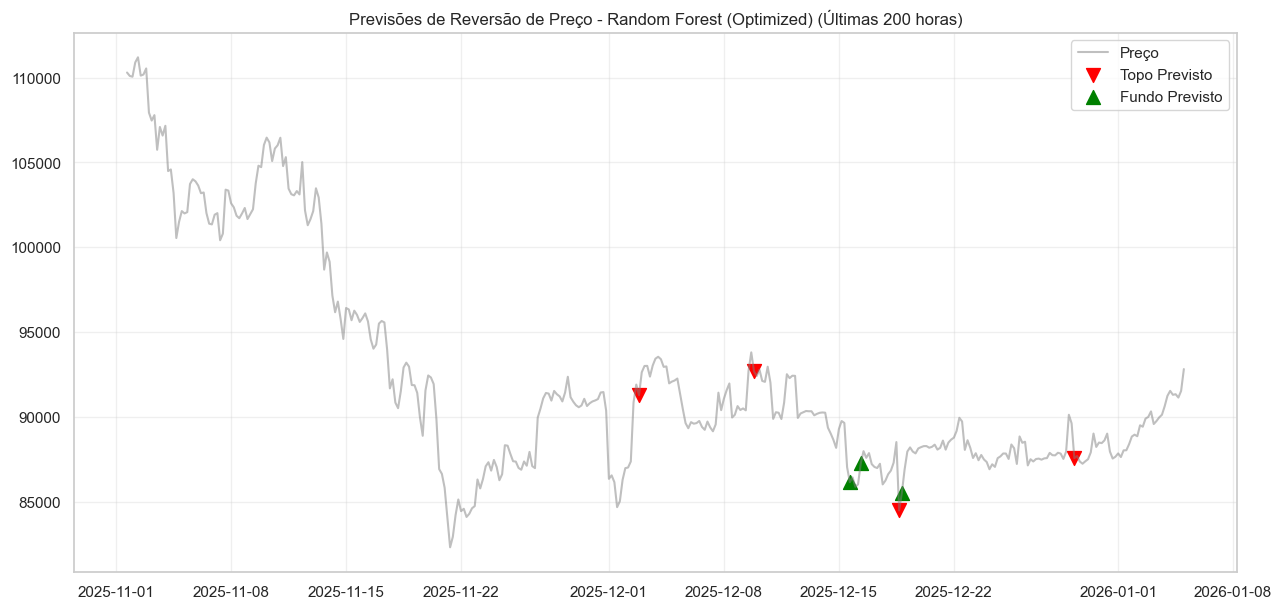

In [9]:
model_name = 'Random Forest (Optimized)'
metrics = results[model_name]

print(f"Acurácia: {metrics['accuracy']:.4f}")
print("Relatório de Classificação:")
print(metrics['report'])

plot_confusion_matrix(y_test, metrics['y_pred'], model_name, show=True)
plot_predictions_on_price(test_dates, test_close, y_test, metrics['y_pred'], model_name, show=True)

### 4.3 Neural Network (LSTM - Deep Learning)

Acurácia: 0.4444
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.46      0.60       331
           1       0.11      0.23      0.14        31
           2       0.08      0.48      0.14        25

    accuracy                           0.44       387
   macro avg       0.35      0.39      0.30       387
weighted avg       0.75      0.44      0.54       387



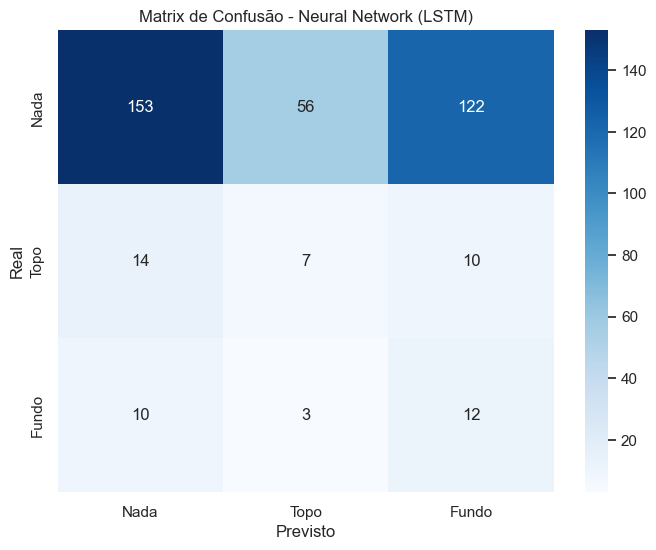

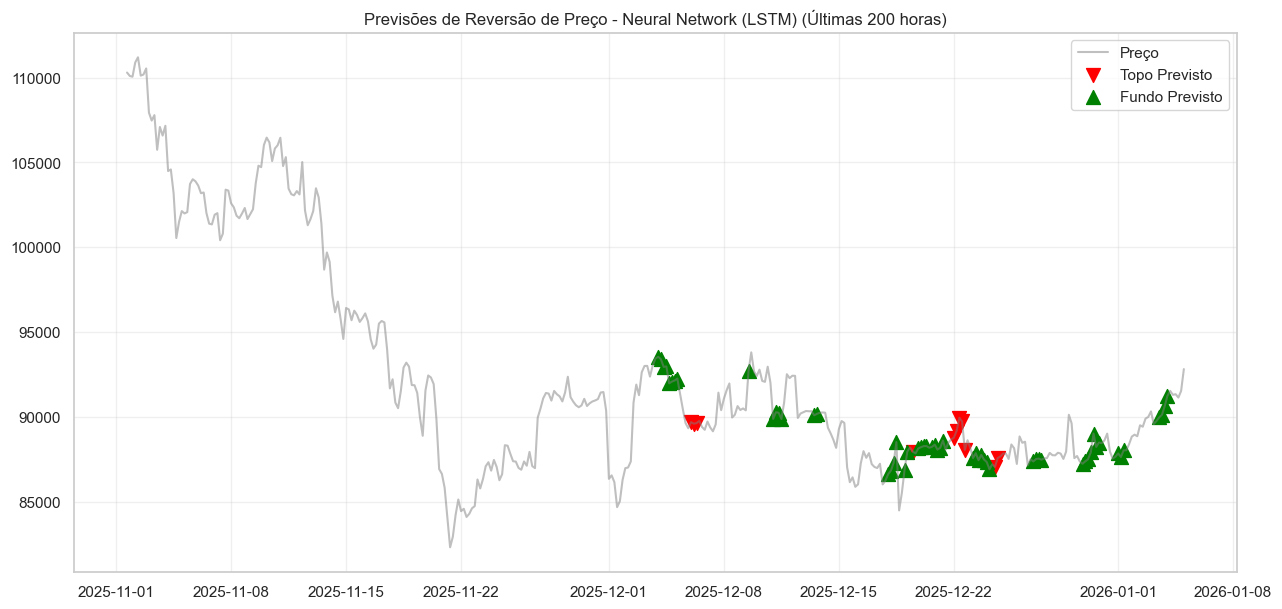

In [10]:
model_name = 'Neural Network (LSTM)'
metrics = results[model_name]

print(f"Acurácia: {metrics['accuracy']:.4f}")
print("Relatório de Classificação:")
print(metrics['report'])

plot_confusion_matrix(y_test, metrics['y_pred'], model_name, show=True)
plot_predictions_on_price(test_dates, test_close, y_test, metrics['y_pred'], model_name, show=True)